# Header

In [1]:
import os

## Notebook Configuration

In [2]:
# path to the this notebook
# NOTE: Replace this with your project path if needed
PROJECT_PATH = (
    "/content/drive/My Drive/W210"
    if "google.colab" in str(get_ipython())
    else "."
)

# path to the data folder
# NOTE: Replace this with your data path if needed
DATA_PATH = f"{PROJECT_PATH}/data" if "google.colab" in str(get_ipython()) else PROJECT_PATH
# NOTE: For colab we use content so it doesn't load on google drive storage
RAW_DATA_PATH = f"{PROJECT_PATH}/data" if "google.colab" in str(get_ipython()) else f"{PROJECT_PATH}/data"

## Colab Setup

In [3]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    # setup libraries used by notebook
    #os.system("pip install -q kaggle")

os.chdir(PROJECT_PATH)

Mounted at /content/drive


NameError: name 'os' is not defined

## Library Import

In [4]:
import itertools
import json
import requests
import shutil
import typing
import zipfile

from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

---

# Data Load

In [5]:
fda = pd.read_csv(f"{DATA_PATH}/FDA_data.csv", dtype=str)
shortages = pd.read_parquet(f"{DATA_PATH}/preprocessed/shortages.parquet")
ndc_df = pd.read_parquet(f"{DATA_PATH}/preprocessed/comp_ndc.parquet")
packaging_df = pd.read_parquet(f"{DATA_PATH}/preprocessed/comp_packaging.parquet")

# Data Pre-Processing

In [6]:
# Get webscrape start and end date
min_date = pd.to_datetime(fda['latest_date'].min().split(' ')[0])
max_date = pd.to_datetime(fda['latest_date'].max().split(' ')[0])

In [10]:
# Get unique NDCs from NDC directory
ndcs = (
    packaging_df.merge(
        ndc_df.reindex(columns=["product_ndc", "date", "listing_expiration_date"])
        .drop_duplicates()
    )
    .merge(
        shortages.groupby("ndc", as_index=False)["date"]
        .max()
        .rename(columns={"date": "shortage_date"})
        .assign(shortage_date=lambda f: f["shortage_date"].dt.strftime("%Y%m%d")),
        on="ndc",
        how="left",
    )
    .assign(shortage_date=lambda f: f["shortage_date"].fillna("20301231"))
    .assign(marketing_end_date=lambda f: f["marketing_end_date"].fillna("20301231"))
    .assign(listing_expiration_date=lambda f: f["listing_expiration_date"].fillna("20301231"))
    .assign(
        marketing_start_date=lambda f: pd.to_datetime(f["marketing_start_date"].astype(str)).dt.strftime("%Y%m%d"),
        marketing_end_date=lambda f: pd.to_datetime(f["marketing_end_date"].astype(str)).dt.strftime("%Y%m%d"),
        date=lambda f: pd.to_datetime(f["date"]).dt.strftime("%Y%m%d"),
        fda_min_date=min_date.strftime("%Y%m%d"),
        fda_max_date=max_date.strftime("%Y%m%d"),
    )
    .assign(
        min_date=lambda f: f[["marketing_start_date", "fda_min_date"]].max(axis=1),
        max_date=lambda f: f[["marketing_end_date", "listing_expiration_date", "fda_max_date", "shortage_date", "date"]].min(axis=1),
    )
    .groupby(["package_ndc", "ndc"], as_index=False)
    .agg({"min_date": "min", "max_date": "max"})
    .assign(
        min_date=lambda f: f["min_date"].astype(int).astype(str),
        max_date=lambda f: f["max_date"].astype(int).astype(str),
    )
    .assign(date=lambda f: f.apply(lambda row: pd.date_range(row["min_date"], row["max_date"]), axis=1))
    .drop(columns=["min_date", "max_date"])
    .explode("date")
    .reset_index(drop=True)
)

In [12]:
# create the time series
shortages_ts = (
    ndcs.merge(shortages, on=["ndc", "date"], how="left")
    .assign(shortage_indicator=lambda f: f["shortage_indicator"].fillna(0).astype(int))
    .groupby(["package_ndc", "date"])["shortage_indicator"]
    .max()
    .reset_index()
)

<Axes: xlabel='date'>

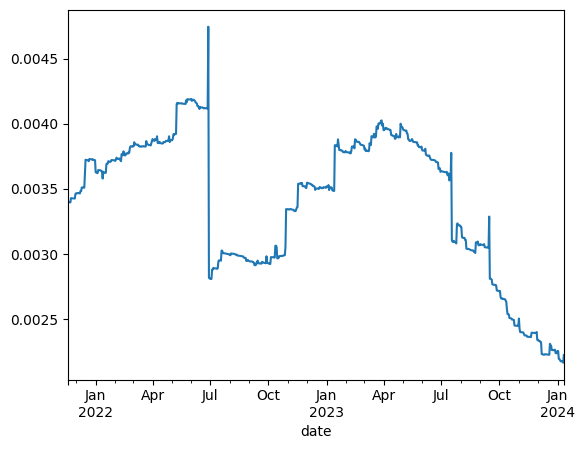

In [13]:
shortages_ts.groupby("date")["shortage_indicator"].mean().plot()

In [14]:
shortages_monday = shortages_ts.loc[lambda f: f["date"].dt.dayofweek == 0]

<Axes: xlabel='date'>

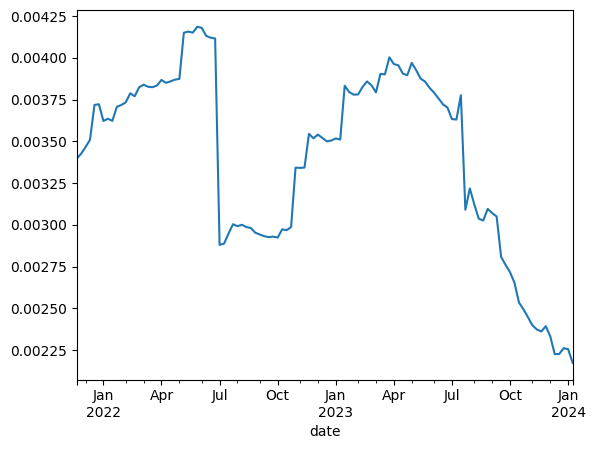

In [15]:
shortages_monday.groupby("date")["shortage_indicator"].mean().plot()

In [ ]:
shortages_ts = pd.read_parquet(f"{DATA_PATH}/preprocessed/shortages_ts.parquet")
shortages_month = (
    shortages_ts.assign(date=lambda f: f["date"] - pd.offsets.MonthBegin(1, normalize=True))
    .assign(date=lambda f: f["date"].dt.date)
    .groupby(["package_ndc", "ndc", "date"])["shortage_indicator"]
    .max()
    .reset_index()
)

In [ ]:
shortages_month.groupby("date")["shortage_indicator"].mean().plot()

# Export

In [16]:
shortages_monday.to_parquet(f"{DATA_PATH}/preprocessed/shortages_monday.parquet", index=False)

In [ ]:
shortages_month.to_parquet(f"{DATA_PATH}/preprocessed/shortages_month.parquet", index=False)

In [ ]:
shortages_ts.astype({"date": "datetime64[ms]"}).to_parquet(f"{DATA_PATH}/preprocessed/shortages_ts.parquet", index=False)

---